In [1]:
# !pip install torchvision
!pip uninstall pillow -y
!pip install --no-cache-dir -I pillow

Uninstalling Pillow-5.2.0:
  Successfully uninstalled Pillow-5.2.0
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 2.0MB 22.5MB/s ta 0:00:01
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


loading all required libraries

In [2]:
#%reload_ext autoreload        
#%autoreload 0
%matplotlib inline

import os
import time
import copy
import math
import torch
import random
import shutil
import scipy.io
import numpy as np
import torchvision
import pandas as pd
from PIL import Image
import torch.nn as nn
from random import randint
import torch.optim as optim
from collections import Counter
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch.utils.data as data
from torchvision import transforms
from torch.autograd import Variable

given information -- create dictionaries for name->class_idx and class_idx->name for all labels

In [3]:
category_idx_labels = {0: 'shirt', 1: 'sweater', 2: 't_shirt', 3: 'outerwear', 4: 'suit', 5: 'tank_top', 6: 'dress'}
gender_idx_labels = {0: 'male', 1: 'female'}
sleevelength_idx_labels = {0: 'no_sleeves', 1: 'short_sleeves', 2: 'long_sleeves'}
idx_to_name_dict = {'category': category_idx_labels, 'gender': gender_idx_labels, 'sleevelength': sleevelength_idx_labels}

In [4]:
category_name_labels = {b:a for a,b in category_idx_labels.items()}
gender_name_labels = {b:a for a,b in gender_idx_labels.items()}
sleevelength_name_labels = {b:a for a,b in sleevelength_idx_labels.items()}
name_to_idx_dict = {'category': category_name_labels, 'gender': gender_name_labels, 'sleevelength': sleevelength_name_labels}

get the data from .mat files and populate the missing values by random if required

In [5]:
def mat_to_target_df(path_to_mat):
    attr_df = pd.DataFrame()
    set_idx = 1
    for fil in os.listdir(path_to_mat):
        feature_name = fil[:-7]
        if feature_name in idx_to_name_dict:
            vals = (scipy.io.loadmat(path_to_mat+fil)['GT'].flatten()) -1 
            attr_df[feature_name] = vals
            attr_df.index = np.arange(1, len(vals)+1)
    return attr_df

In [6]:
df_with_nan = mat_to_target_df('./ClothingAttributeDataset/labels/')
df_with_nan.head(6)

,sleevelength,category,gender
1,2.0,4.0,0.0
2,2.0,NaN,1.0
3,2.0,3.0,0.0
4,2.0,4.0,1.0
5,0.0,5.0,1.0
6,2.0,NaN,0.0


In [7]:
df_usable = df_with_nan.dropna()
df_usable.head(6)

,sleevelength,category,gender
1,2.0,4.0,0.0
3,2.0,3.0,0.0
4,2.0,4.0,1.0
5,0.0,5.0,1.0
7,2.0,3.0,0.0
8,2.0,1.0,1.0


function that populates the nan values with random class_idx

In [8]:
def populate_nan_by_random(data_df,idx_to_name_dict):
    df = data_df.copy()
    for row in range(1,len(df)+1):
        for col in df.columns:
            if math.isnan(df.loc[row,col]):
                df.loc[row,col] = float(random.choice(list(idx_to_name_dict[col].keys())))
    return df

In [9]:
df_populated = populate_nan_by_random(df_with_nan,idx_to_name_dict)
df_populated.head(6)

,sleevelength,category,gender
1,2.0,4.0,0.0
2,2.0,2.0,1.0
3,2.0,3.0,0.0
4,2.0,4.0,1.0
5,0.0,5.0,1.0
6,2.0,4.0,0.0


visualise the class distribution for each of the labels

In [10]:
def mat_to_label_df(path_to_mat):
    attr_df = pd.DataFrame()
    set_idx = 1
    for fil in os.listdir(path_to_mat):
        feature_name = fil[:-7]
        if feature_name in idx_to_name_dict:
            vals = (scipy.io.loadmat(path_to_mat+fil)['GT'].flatten()) -1
            c = Counter(vals)
            ans = c.most_common()
            freq = {}
            nan_count = 0          
            for ctr in ans:
                if math.isnan(ctr[0]):
                    nan_count += 1
                    continue
                if ctr[0] in freq.keys():
                    freq[idx_to_name_dict[feature_name].get(int(ctr[0]))] += 1
                else:
                    freq[idx_to_name_dict[feature_name].get(int(ctr[0]))] = ctr[1]
            freq['nan'] = nan_count
            print(freq)
            new_vals = []
            plt.title("class distribution for %s" % feature_name)
            plt.bar(list(freq.keys()), freq.values(), color='g')
            plt.show()

{'long_sleeves': 1270, 'short_sleeves': 323, 'no_sleeves': 188, 'nan': 75}


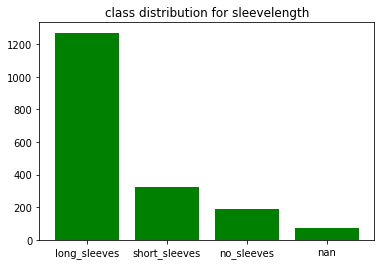

{'dress': 260, 'suit': 232, 'outerwear': 220, 'shirt': 134, 't_shirt': 108, 'sweater': 88, 'tank_top': 62, 'nan': 752}


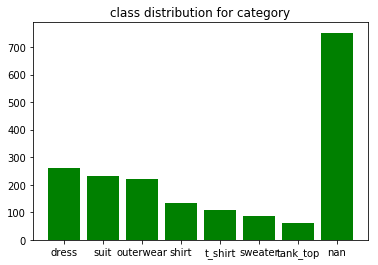

{'female': 1032, 'male': 762, 'nan': 62}


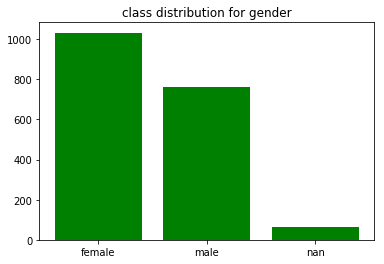

In [11]:
mat_to_label_df('./ClothingAttributeDataset/labels/')

we see that class imbalance is most for sleevelength label, however we don't try to fix that; instead we ensure that there's no dataset/covariate shift

In [12]:
def train_test_split(path_to_images,attributedf,train_size=0.8,val_size=0.1):
    data_size = len(attributedf)
    print("initially, data set has "+str(len(attributedf))+" images")
    train = attributedf.sample(n=int(data_size*train_size),replace=False)#,random_state=0)
    attributedf = attributedf.drop(train.index)
    print("train set has "+str(len(train))+" images")
    val = attributedf.sample(n=int(data_size*val_size),replace=False)
    attributedf = attributedf.drop(val.index)#,inplace=True)
    print("val set has "+str(len(val))+" images")
    test = attributedf.sample(n=int(len(attributedf)),replace=False)
    attributedf = attributedf.drop(test.index)#,inplace=True)
    print("test set has "+str(len(test))+" images")
    print("finally, data set has "+str(len(attributedf))+" images")
    return train,val,test

In [13]:
train,val,test = train_test_split('./ClothingAttributeDataset/images/',df_usable)

initially, data set has 1035 images
train set has 828 images
val set has 103 images
test set has 104 images
finally, data set has 0 images


now that we have split out our data in train, val and test, we ensure uniform distribution of classes within them for all labels to overcome class imbalance issue

In [14]:
def plot_distribution(train,val,test):
    for col in train.columns:
        fig, axes = plt.subplots(1, 3)
        fig.figsize = (30,40)
        fig.set_size_inches(24, 4.5)
        fig.align_xlabels()
        train.hist(column=col,xlabelsize=14,ylabelsize=14,ax=axes[0])
        axes[0].set_title('Train - %s' % col, fontsize=12)
        val.hist(column=col,xlabelsize=14,ylabelsize=14,ax=axes[1])
        axes[1].set_title('Val - %s' % col, fontsize=12)
        test.hist(column=col,xlabelsize=14,ylabelsize=14,ax=axes[2])
        axes[2].set_title('Test - %s' % col, fontsize=12)

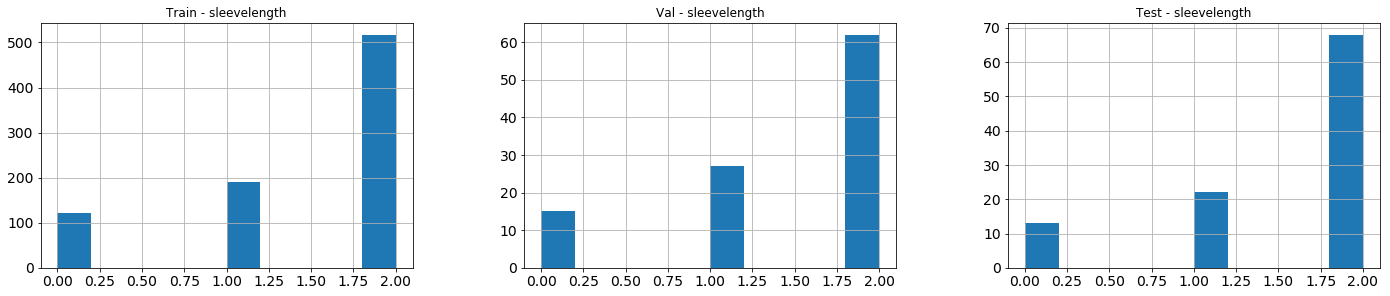

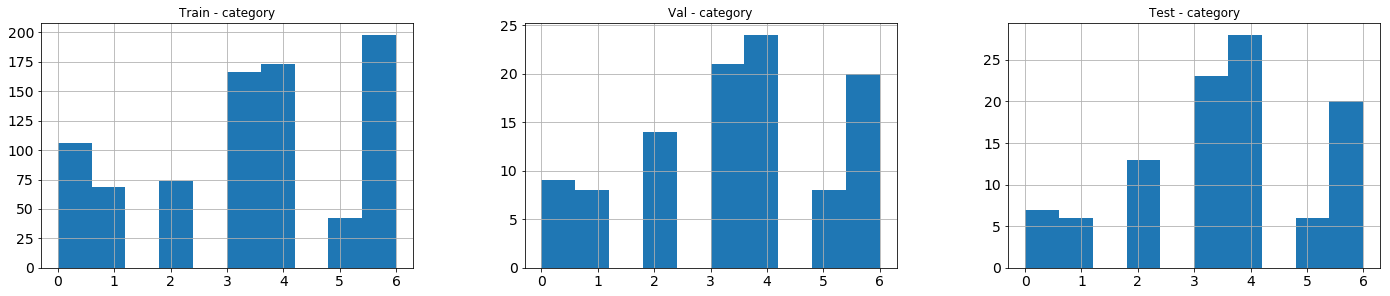

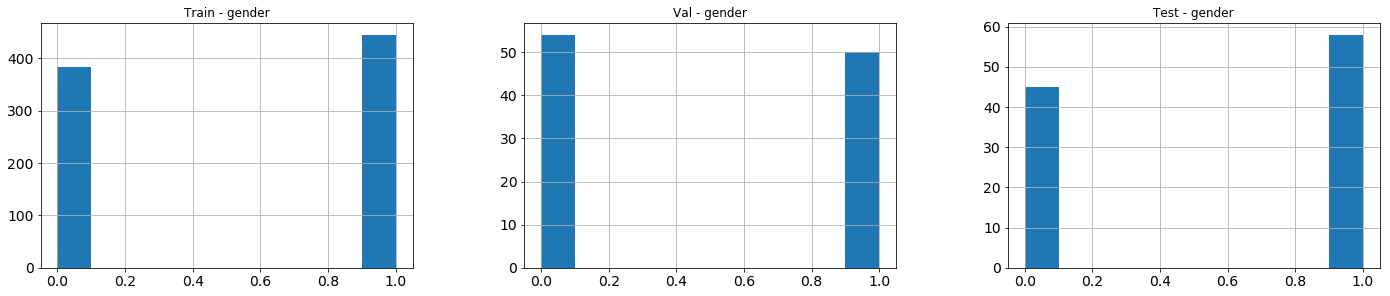

In [15]:
plot_distribution(train,test,val)

since class distribution is quite uniform for all labels across train-val-test splits, not to worry about imbalance; splitting the images into train, val and test folders

In [16]:
def form_tts_dataset(path_to_images,train,val,test):
    if 'train' not in os.listdir(os.getcwd()):
        os.makedirs('train')
    if 'val' not in os.listdir(os.getcwd()):
        os.makedirs('val')
    if 'test' not in os.listdir(os.getcwd()):
        os.makedirs('test')
    for index, row in train.iterrows():
        shutil.copyfile('./ClothingAttributeDataset/images/'+str(index).zfill(6)+'.jpg', './train/'+str(index).zfill(6)+'.jpg') 
    for index, row in val.iterrows():
        shutil.copyfile('./ClothingAttributeDataset/images/'+str(index).zfill(6)+'.jpg', './val/'+str(index).zfill(6)+'.jpg') 
    for index, row in test.iterrows():
        shutil.copyfile('./ClothingAttributeDataset/images/'+str(index).zfill(6)+'.jpg', './test/'+str(index).zfill(6)+'.jpg') 

In [17]:
!rm -rf train test val
form_tts_dataset('./ClothingAttributeDataset/images/',train,val,test)

getting the mean and std of RGB values of the train images for image normalisation later on.. if required

In [18]:
def get_RGB(path_to_train_set):
    idx = 0
    r = []
    g = []
    b = []
    for fil in os.listdir(path_to_train_set):
        img = Image.open(path_to_train_set+fil)
        arr = np.array(img)
        r.append(np.mean(arr, axis=(0, 1))[0])
        g.append(np.mean(arr, axis=(0, 1))[1])
        b.append(np.mean(arr, axis=(0, 1))[2])
    r = [np.mean(r),np.std(r)]
    g = [np.mean(g),np.std(g)]
    b = [np.mean(b),np.std(b)]
    return (r,g,b)

In [19]:
r_val,g_val,b_val = get_RGB('./train/')

checking most common occuring image size for cropping later on.. if required

In [20]:
def get_size(path_to_train_set):
    minw=np.inf
    minh=np.inf
    maxh=0
    maxw=0
    sizfreq = []
    for fil in os.listdir(path_to_train_set):
        im = Image.open(path_to_train_set+fil)
        siz = im.size
        sizfreq.append(siz)
        minw = min(minw,siz[0])
        maxw = max(maxw,siz[0])
        minh = min(minh,siz[1])
        maxh = max(maxh,siz[1])
    commonsiz = Counter(sizfreq).most_common()[0]
    print("the most common size is ",commonsiz[0][0], "(W) x ",commonsiz[0][1], "(H)")
    return ((minw,minh),(maxw,maxh),(commonsiz[0][1],commonsiz[0][0]))

In [21]:
crop_siz = get_size('./train/')[2]

the most common size is  266 (W) x  400 (H)


creating a class for converting the raw image data into torch dataset

In [22]:
class OneLabelDataset(data.Dataset):
    """
    creates a dataset for that label

    arguments:
        path_to_data : path to data folder
        target_df : dataframe containing target values
        attrname : attribute/label name
        transform : data transformer
    """
    def __init__(self, path_to_data, target_df, attrname, transform=None):
        super().__init__()
        
        self.path_to_data = path_to_data
        self.target_df = target_df
        self.attrname = attrname
        self.transform = transform
        self.data = self.get_data()
    
    def get_data(self):
        datalist = []
        for file_location in os.listdir(self.path_to_data):
            imgindex = file_location[:-4].lstrip('0')
            target_value = self.target_df.loc[int(imgindex), self.attrname]
            datalist.append((self.path_to_data+file_location,int(target_value)))
        return datalist
    
    def __getitem__(self, idx):
        path, target = self.data[idx]
        dataitem = Image.open(path).convert('RGB')
        if self.transform is not None:
            dataitem = self.transform(dataitem)
        return path, dataitem, target

    def __len__(self):
        return len(self.data)

class that does the training!

In [23]:
class ModelTrainer():
    """
    creates a trainer object for that label

    arguments:
        train_set : train set data loader
        val_set : val set data loader
        attribte : attribute/label name
        criterion : loss criterion
        lr_start : initial learning rate
        lr_decay : learning rate decay factor
        use_gpu : if gpu available
    """
    def __init__(
    self, train_set, val_set, attribte, criterion=nn.CrossEntropyLoss(), lr_start=0.01, lr_decay=8, use_gpu=True):

        self.use_gpu = use_gpu
        self.train_set = train_set
        self.val_set = val_set
        self.attribte = attribte
        self.criterion = criterion
        self.lr_start = lr_start
        self.lr_decay = lr_decay
        self.iterations = 0
        self.model = self.model_generator()
        self.bp_optimiser = None
    
    def model_generator(self):
        premodel = torchvision.models.resnet34(pretrained=True)
        for param in premodel.parameters():
            param.requires_grad = True
        premodel.fc = nn.Sequential(*[
            nn.Dropout(p=0.8),
            nn.Linear(512, 512),
            nn.Linear(512,len(name_to_idx_dict[self.attribte]))
            ])
        premodel.avgpool = nn.AdaptiveAvgPool2d(1)
        if self.use_gpu and torch.cuda.is_available():
            premodel=premodel.cuda()
            self.criterion.cuda()
        return premodel
  
    def optim_sched(self,num_epoch):
        lr = self.lr_start * (1.5**(num_epoch//self.lr_decay))
        optimizer = optim.SGD(self.model.parameters(), lr=lr, momentum=0.90, weight_decay=1e-2)
        return (optimizer,lr)
        
    def run(self,num_epochs=10,report_batch_stats=True):
        start_time = time.time()
        best_model = self.model
        best_acc = 0.0
        res = []
        trainloss = []
        valloss = []
        trainaccuracy = []
        valaccuracy = []
        batch_loss_tr = []
        batch_acc_tr = []
        batch_loss_val = []
        batch_acc_val = []
        epochnumber = []
        iternumber = []
        for epoch in range(num_epochs):
            dset_size = 0
            epoch_loss = 0.0
            epoch_corr = 0.0
            optmzr, lrate = self.optim_sched(epoch)
            print("the epoch number {} out of {}".format(epoch, num_epochs - 1))
            print("the learning rate is {}".format(lrate)) 
            for batchidx,data in enumerate(self.train_set):
                print("batch number is",batchidx)                
                impath, inputs, targets = data
                if self.use_gpu:
                    inputs, targets = inputs.cuda(), targets.cuda()
                outputs = self.model(inputs)
                predictions = outputs.data.max(1)[1]    
                loss = self.criterion(outputs, targets)
                optmzr.zero_grad()
                loss.backward()
                optmzr.step()
                epoch_loss += loss
                epoch_corr += torch.sum(predictions == targets.data)
                batch_corr = torch.sum(predictions == targets.data).cpu().numpy()
                b_loss_tr = (float(loss) / len(targets.data))
                b_acc_tr = (batch_corr/len(targets.data))
                if report_batch_stats:
                    print("the batch loss is ", '%.4f' % b_loss_tr) 
                    print("the batch accuracy is ", '%.4f' % b_acc_tr)
                self.iterations = self.iterations + 1
                dset_size += len(targets.data)
                if epoch == num_epochs-1:
                    res.append((impath,predictions))
                batch_loss_tr.append(b_loss_tr)
                batch_acc_tr.append(b_acc_tr)
                b_acc_val, b_loss_val = self.calc_batch_stats(inputs,targets) 
                batch_loss_val.append(b_loss_val)
                batch_acc_val.append(b_acc_val)
                iternumber.append(self.iterations)
                self.iterations += 1
            (trnstat, valstat) = self.report_epoch_stats(epoch) 
            trainaccuracy.append(trnstat[0])
            valaccuracy.append(valstat[0])
            trainloss.append(trnstat[1])
            valloss.append(valstat[1])
            epochnumber.append(epoch)
        self.plot_graph(iternumber,batch_loss_tr,batch_loss_val,'loss')
        self.plot_graph(iternumber,batch_acc_tr,batch_acc_val,'accuracy')
        time_taken = time.time() - start_time
        print("the training took {:0f}min {:0f}sec".format(time_taken // 60, time_taken % 60))
        return best_model
    
    def requires_grad(self, model, val=True):
        for param in model.parameters():
            param.requires_grad = val
    
    def report_epoch_stats(self,epoch):
        print('\n')
        print("stats for epoch number {}".format(epoch))
        accuracy, loss = self.calc_epoch_stats(self.train_set)
        accuracy_val, loss_val = self.calc_epoch_stats(self.val_set)
        print('accuracy: ', '%.4f' % accuracy, '(train)', '%.4f' % accuracy_val, '(val)')
        print('loss: ', '%.4f' % loss, '(train)', '%.4f' % loss_val, '(val)')
        print("------------------------------------------------------------")
        return ((accuracy,loss), (accuracy_val,loss_val))

    def calc_epoch_stats(self,dataset):
        accuracy = []
        loss = []
        for (_,x, y) in dataset:
            if self.use_gpu:
                x, y = x.cuda(), y.cuda()
            self.requires_grad(self.model, False)
            y_pred = self.model(x)
            self.requires_grad(self.model)
            y_pred_class = y_pred.data.max(1)[1]
            accuracy.append(float((y == y_pred_class).sum()) / len(y))
            loss.append(float(self.criterion(y_pred, y)) / len(y))
        return np.mean(accuracy), np.mean(loss)
    
    def calc_batch_stats(self,x,y):
        accuracy = []
        loss = []
        if self.use_gpu:
            x, y = x.cuda(), y.cuda()
        self.requires_grad(self.model, False)
        y_pred = self.model(x)
        self.requires_grad(self.model)
        y_pred_class = y_pred.data.max(1)[1]
        accuracy.append(float((y == y_pred_class).sum()) / len(y))
        loss.append(float(self.criterion(y_pred, y)) / len(y))
        return np.mean(accuracy), np.mean(loss)
    
    def plot_graph(self,iternum,trn,val,plottype):
        print("plotting...")
        plt.plot(iternum,trn,'b')
        plt.plot(iternum,val,'r')
        if plottype == 'accuracy':
            plt.title("iteration vs accuracy")
            plt.ylabel('accuracy')
            plt.xlabel('iteration')
            plt.legend(['train', 'val'], loc='lower right')
        else:
            plt.title("iteration vs loss")
            plt.ylabel('loss')
            plt.xlabel('iteration')
            plt.legend(['train', 'val'], loc='upper right')
        plt.show()

class that is used for testing our model!

In [24]:
class ModelTester():
    """
    creates a testing object for that label

    arguments:
        test_set : test set data loader
        model : the best model
        attribte : attribute/label name
        use_gpu : if gpu available
    """
    def __init__(
    self, test_set, model, attribte, use_gpu=True):
        self.use_gpu = use_gpu
        self.test_set = test_set
        self.attribte = attribte
        self.iterations = 0
        self.model = model
        
    def test(self,report_batch_stats=True):
        if self.use_gpu is None:
            self.use_gpu = torch.cuda.is_available()
        self.model.eval()
        res = []
        testaccuracy = []
        for batch_idx, dset in enumerate(self.test_set):
            print("batch number is",batch_idx)
            imgpath , inputs, targets = dset
            if self.use_gpu:
                inputs, targets = inputs.cuda(), targets.cuda()
                self.model = self.model.cuda()
            outputs = self.model(inputs)
            _, preds = outputs.data.max(1)
            predlist = preds.cpu().numpy().flatten()
            test_corr = torch.sum(preds == targets.data).cpu().numpy()
            testaccuracy.append(test_corr/len(targets.data))
            if report_batch_stats:
                print("the batch accuracy is ", test_corr/len(targets.data)) 
            for vl in range(len(predlist)):
                res.append((imgpath[vl],predlist[vl]))
        print("--------------------------------------------")
        print("the test accuracy is ", np.mean(testaccuracy))
        return res

defining transforms for train and test set separately

In [25]:
train_transform = transforms.Compose([
            transforms.Resize(266),
            transforms.CenterCrop(crop_siz),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            ])
test_transform = transforms.Compose([
            transforms.Resize(266),
            transforms.CenterCrop(crop_siz),
            transforms.ToTensor()
            ])

converting raw images into datasets

In [26]:
train_sleevelength = OneLabelDataset('./train/', train, 'sleevelength',transform=train_transform)
val_sleevelength = OneLabelDataset('./val/', val, 'sleevelength',transform=test_transform)
test_sleevelength = OneLabelDataset('./test/', test, 'sleevelength',transform=test_transform)
train_category = OneLabelDataset('./train/', train, 'category',transform=train_transform)
val_category = OneLabelDataset('./val/', val, 'category',transform=test_transform)
test_category = OneLabelDataset('./test/', test, 'category',transform=test_transform)
train_gender = OneLabelDataset('./train/', train, 'gender',transform=train_transform)
val_gender = OneLabelDataset('./val/', val, 'gender',transform=test_transform)
test_gender = OneLabelDataset('./test/', test, 'gender',transform=test_transform)

converting torch datasets to dataloaders

In [27]:
train_sleevelength_loader = data.DataLoader(train_sleevelength, batch_size=32,shuffle=True, num_workers=0)
val_sleevelength_loader = data.DataLoader(val_sleevelength, batch_size=32,shuffle=True, num_workers=0)
test_sleevelength_loader = data.DataLoader(test_sleevelength, batch_size=32,shuffle=True, num_workers=0)
train_category_loader = data.DataLoader(train_category, batch_size=32,shuffle=True, num_workers=0)
val_category_loader = data.DataLoader(val_category, batch_size=32,shuffle=True, num_workers=0)
test_category_loader = data.DataLoader(test_category, batch_size=32,shuffle=True, num_workers=0)
train_gender_loader = data.DataLoader(train_gender, batch_size=32,shuffle=True, num_workers=0)
val_gender_loader = data.DataLoader(val_gender, batch_size=32,shuffle=True, num_workers=0)
test_gender_loader = data.DataLoader(test_gender, batch_size=32,shuffle=True, num_workers=0)

training and testing for sleevelength label

the epoch number 0 out of 9
the learning rate is 0.01
batch number is 0
the batch loss is  0.0274
the batch accuracy is  0.2812
batch number is 1
the batch loss is  0.0132
the batch accuracy is  0.5938
batch number is 2
the batch loss is  0.0160
the batch accuracy is  0.6250
batch number is 3
the batch loss is  0.0198
the batch accuracy is  0.6562
batch number is 4
the batch loss is  0.0172
the batch accuracy is  0.6250
batch number is 5
the batch loss is  0.0389
the batch accuracy is  0.3750
batch number is 6
the batch loss is  0.0140
the batch accuracy is  0.6562
batch number is 7
the batch loss is  0.0200
the batch accuracy is  0.4375
batch number is 8
the batch loss is  0.0116
the batch accuracy is  0.7500
batch number is 9
the batch loss is  0.0137
the batch accuracy is  0.7188
batch number is 10
the batch loss is  0.0154
the batch accuracy is  0.5312
batch number is 11
the batch loss is  0.0169
the batch accuracy is  0.6250
batch number is 12
the batch loss is  0.0099
the batch a

batch number is 23
the batch loss is  0.0007
the batch accuracy is  1.0000
batch number is 24
the batch loss is  0.0028
the batch accuracy is  0.9062
batch number is 25
the batch loss is  0.0023
the batch accuracy is  0.9286


stats for epoch number 3
accuracy:  0.9542 (train) 0.9174 (val)
loss:  0.0013 (train) 0.0070 (val)
------------------------------------------------------------
the epoch number 4 out of 9
the learning rate is 0.01
batch number is 0
the batch loss is  0.0000
the batch accuracy is  1.0000
batch number is 1
the batch loss is  0.0016
the batch accuracy is  0.9062
batch number is 2
the batch loss is  0.0015
the batch accuracy is  0.9688
batch number is 3
the batch loss is  0.0028
the batch accuracy is  0.8750
batch number is 4
the batch loss is  0.0003
the batch accuracy is  1.0000
batch number is 5
the batch loss is  0.0006
the batch accuracy is  0.9688
batch number is 6
the batch loss is  0.0004
the batch accuracy is  1.0000
batch number is 7
the batch loss is  0.00

the batch loss is  0.0009
the batch accuracy is  0.9688
batch number is 18
the batch loss is  0.0001
the batch accuracy is  1.0000
batch number is 19
the batch loss is  0.0005
the batch accuracy is  1.0000
batch number is 20
the batch loss is  0.0000
the batch accuracy is  1.0000
batch number is 21
the batch loss is  0.0005
the batch accuracy is  1.0000
batch number is 22
the batch loss is  0.0000
the batch accuracy is  1.0000
batch number is 23
the batch loss is  0.0034
the batch accuracy is  0.9688
batch number is 24
the batch loss is  0.0000
the batch accuracy is  1.0000
batch number is 25
the batch loss is  0.0000
the batch accuracy is  1.0000


stats for epoch number 7
accuracy:  0.9615 (train) 0.8783 (val)
loss:  0.0011 (train) 0.0151 (val)
------------------------------------------------------------
the epoch number 8 out of 9
the learning rate is 0.015
batch number is 0
the batch loss is  0.0018
the batch accuracy is  0.9688
batch number is 1
the batch loss is  0.0008
the batch

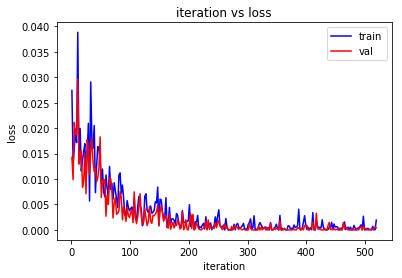

plotting...


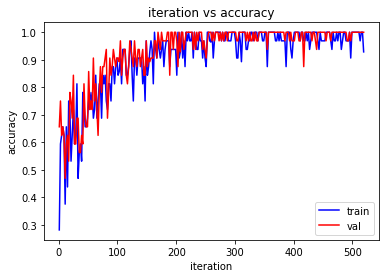

the training took 11.000000min 51.168824sec


In [28]:
trainer1 = ModelTrainer(train_sleevelength_loader, val_sleevelength_loader, 'sleevelength', criterion=nn.MultiMarginLoss())
trainer1_model = trainer1.run(num_epochs=10,report_batch_stats=True)

In [29]:
tester1 = ModelTester(test_sleevelength_loader, trainer1_model, 'sleevelength', idx_to_name_dict)
outp1 = tester1.test()

batch number is 0
the batch accuracy is  0.90625
batch number is 1
the batch accuracy is  0.90625
batch number is 2
the batch accuracy is  0.875
batch number is 3
the batch accuracy is  0.875
--------------------------------------------
the test accuracy is  0.890625


training and testing for category label

the epoch number 0 out of 9
the learning rate is 0.01
batch number is 0
the batch loss is  0.0283
the batch accuracy is  0.1875
batch number is 1
the batch loss is  0.0289
the batch accuracy is  0.0625
batch number is 2
the batch loss is  0.0190
the batch accuracy is  0.3125
batch number is 3
the batch loss is  0.0222
the batch accuracy is  0.1562
batch number is 4
the batch loss is  0.0298
the batch accuracy is  0.2500
batch number is 5
the batch loss is  0.0226
the batch accuracy is  0.2500
batch number is 6
the batch loss is  0.0261
the batch accuracy is  0.2500
batch number is 7
the batch loss is  0.0278
the batch accuracy is  0.1562
batch number is 8
the batch loss is  0.0276
the batch accuracy is  0.2812
batch number is 9
the batch loss is  0.0204
the batch accuracy is  0.3125
batch number is 10
the batch loss is  0.0228
the batch accuracy is  0.2500
batch number is 11
the batch loss is  0.0208
the batch accuracy is  0.2188
batch number is 12
the batch loss is  0.0220
the batch a

batch number is 23
the batch loss is  0.0050
the batch accuracy is  0.7500
batch number is 24
the batch loss is  0.0056
the batch accuracy is  0.8125
batch number is 25
the batch loss is  0.0079
the batch accuracy is  0.5714


stats for epoch number 3
accuracy:  0.7768 (train) 0.7210 (val)
loss:  0.0037 (train) 0.0148 (val)
------------------------------------------------------------
the epoch number 4 out of 9
the learning rate is 0.01
batch number is 0
the batch loss is  0.0022
the batch accuracy is  0.8438
batch number is 1
the batch loss is  0.0027
the batch accuracy is  0.8750
batch number is 2
the batch loss is  0.0019
the batch accuracy is  0.9062
batch number is 3
the batch loss is  0.0043
the batch accuracy is  0.7500
batch number is 4
the batch loss is  0.0015
the batch accuracy is  0.9062
batch number is 5
the batch loss is  0.0034
the batch accuracy is  0.7500
batch number is 6
the batch loss is  0.0046
the batch accuracy is  0.7812
batch number is 7
the batch loss is  0.00

the batch loss is  0.0018
the batch accuracy is  0.8750
batch number is 18
the batch loss is  0.0009
the batch accuracy is  0.9688
batch number is 19
the batch loss is  0.0015
the batch accuracy is  0.8750
batch number is 20
the batch loss is  0.0012
the batch accuracy is  0.9688
batch number is 21
the batch loss is  0.0033
the batch accuracy is  0.8125
batch number is 22
the batch loss is  0.0007
the batch accuracy is  0.9375
batch number is 23
the batch loss is  0.0012
the batch accuracy is  0.9375
batch number is 24
the batch loss is  0.0019
the batch accuracy is  0.8750
batch number is 25
the batch loss is  0.0021
the batch accuracy is  0.8571


stats for epoch number 7
accuracy:  0.9171 (train) 0.7567 (val)
loss:  0.0011 (train) 0.0125 (val)
------------------------------------------------------------
the epoch number 8 out of 9
the learning rate is 0.015
batch number is 0
the batch loss is  0.0020
the batch accuracy is  0.8750
batch number is 1
the batch loss is  0.0011
the batch

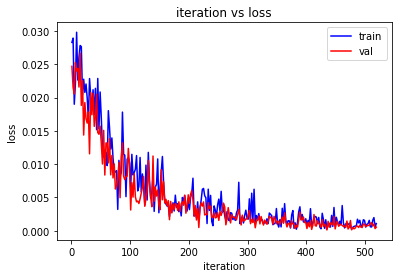

plotting...


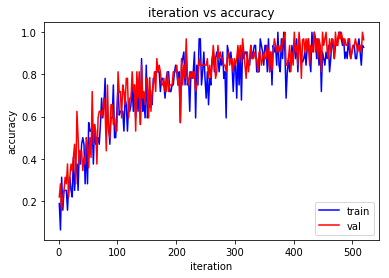

the training took 11.000000min 53.329268sec


In [30]:
trainer2 = ModelTrainer(train_category_loader, val_category_loader, 'category', criterion=nn.MultiMarginLoss())
trainer2_model = trainer2.run(num_epochs=10,report_batch_stats=True)

In [31]:
tester2 = ModelTester(test_category_loader, trainer2_model, 'category', idx_to_name_dict)
outp2 = tester2.test()

batch number is 0
the batch accuracy is  0.71875
batch number is 1
the batch accuracy is  0.5625
batch number is 2
the batch accuracy is  0.71875
batch number is 3
the batch accuracy is  0.625
--------------------------------------------
the test accuracy is  0.65625


training and testing for gender label

the epoch number 0 out of 9
the learning rate is 0.01
batch number is 0
the batch loss is  0.0174
the batch accuracy is  0.5625
batch number is 1
the batch loss is  0.0176
the batch accuracy is  0.5625
batch number is 2
the batch loss is  0.0200
the batch accuracy is  0.5625
batch number is 3
the batch loss is  0.0268
the batch accuracy is  0.4062
batch number is 4
the batch loss is  0.0130
the batch accuracy is  0.6875
batch number is 5
the batch loss is  0.0172
the batch accuracy is  0.4062
batch number is 6
the batch loss is  0.0153
the batch accuracy is  0.5938
batch number is 7
the batch loss is  0.0196
the batch accuracy is  0.5625
batch number is 8
the batch loss is  0.0158
the batch accuracy is  0.5938
batch number is 9
the batch loss is  0.0155
the batch accuracy is  0.6250
batch number is 10
the batch loss is  0.0151
the batch accuracy is  0.5938
batch number is 11
the batch loss is  0.0114
the batch accuracy is  0.6875
batch number is 12
the batch loss is  0.0132
the batch a

batch number is 23
the batch loss is  0.0019
the batch accuracy is  0.9375
batch number is 24
the batch loss is  0.0039
the batch accuracy is  0.9062
batch number is 25
the batch loss is  0.0004
the batch accuracy is  1.0000


stats for epoch number 3
accuracy:  0.9626 (train) 0.8862 (val)
loss:  0.0015 (train) 0.0213 (val)
------------------------------------------------------------
the epoch number 4 out of 9
the learning rate is 0.01
batch number is 0
the batch loss is  0.0010
the batch accuracy is  0.9688
batch number is 1
the batch loss is  0.0024
the batch accuracy is  0.9688
batch number is 2
the batch loss is  0.0007
the batch accuracy is  0.9688
batch number is 3
the batch loss is  0.0005
the batch accuracy is  0.9688
batch number is 4
the batch loss is  0.0010
the batch accuracy is  0.9688
batch number is 5
the batch loss is  0.0039
the batch accuracy is  0.9375
batch number is 6
the batch loss is  0.0016
the batch accuracy is  0.9688
batch number is 7
the batch loss is  0.00

the batch loss is  0.0026
the batch accuracy is  0.9375
batch number is 18
the batch loss is  0.0006
the batch accuracy is  1.0000
batch number is 19
the batch loss is  0.0017
the batch accuracy is  0.9688
batch number is 20
the batch loss is  0.0009
the batch accuracy is  1.0000
batch number is 21
the batch loss is  0.0005
the batch accuracy is  1.0000
batch number is 22
the batch loss is  0.0012
the batch accuracy is  0.9688
batch number is 23
the batch loss is  0.0026
the batch accuracy is  0.9375
batch number is 24
the batch loss is  0.0016
the batch accuracy is  0.9375
batch number is 25
the batch loss is  0.0054
the batch accuracy is  0.8929


stats for epoch number 7
accuracy:  0.9830 (train) 0.9141 (val)
loss:  0.0007 (train) 0.0067 (val)
------------------------------------------------------------
the epoch number 8 out of 9
the learning rate is 0.015
batch number is 0
the batch loss is  0.0008
the batch accuracy is  0.9688
batch number is 1
the batch loss is  0.0001
the batch

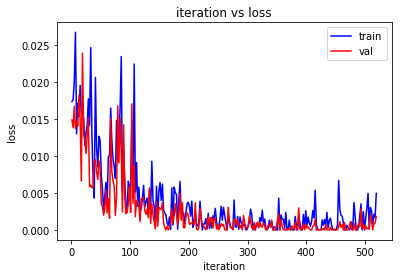

plotting...


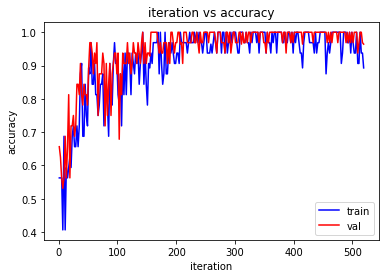

the training took 11.000000min 51.411760sec


In [32]:
trainer3 = ModelTrainer(train_gender_loader, val_gender_loader, 'gender', criterion=nn.MultiMarginLoss())
trainer3_model = trainer3.run(num_epochs=10,report_batch_stats=True)

In [33]:
tester3 = ModelTester(test_gender_loader, trainer3_model, 'gender', idx_to_name_dict)
outp3 = tester3.test()

batch number is 0
the batch accuracy is  1.0
batch number is 1
the batch accuracy is  0.96875
batch number is 2
the batch accuracy is  0.875
batch number is 3
the batch accuracy is  0.875
--------------------------------------------
the test accuracy is  0.9296875


defining the function to combine all label predictions into a dict

In [34]:
def combine_predictions(a,b,c):
    test_pred = {}
    for vl in a:
        if vl[0] in test_pred.keys():
            continue
        else:
            test_pred[vl[0]] = [vl[1]]
    for vl in b:
        test_pred[vl[0]].append(vl[1])
    for vl in c:
        test_pred[vl[0]].append(vl[1])
    return test_pred

In [36]:
combined_dict = combine_predictions(outp1,outp2,outp3)

In [37]:
dict(list(combined_dict.items())[0:5])

{'./test/001814.jpg': [2, 4, 0],
 './test/000528.jpg': [2, 3, 0],
 './test/000508.jpg': [2, 3, 1],
 './test/001269.jpg': [2, 3, 1],
 './test/001841.jpg': [0, 6, 1]}

defining the function to convert class_idx predictions to class_name predictions

In [38]:
def name_predictions(cdict,idx_to_name_dict):
    for img in cdict.keys():
        ctr = 0
        for indx in cdict[img]:
            if ctr==0: cdict[img][ctr] = idx_to_name_dict['sleevelength'][indx]
            if ctr==1: cdict[img][ctr] = idx_to_name_dict['category'][indx]
            if ctr==2: cdict[img][ctr] = idx_to_name_dict['gender'][indx]
            ctr += 1
    return cdict

In [39]:
combined_name_dict = name_predictions(combined_dict,idx_to_name_dict)

In [40]:
dict(list(combined_name_dict.items())[0:5])

{'./test/001814.jpg': ['long_sleeves', 'suit', 'male'],
 './test/000528.jpg': ['long_sleeves', 'outerwear', 'male'],
 './test/000508.jpg': ['long_sleeves', 'outerwear', 'female'],
 './test/001269.jpg': ['long_sleeves', 'outerwear', 'female'],
 './test/001841.jpg': ['no_sleeves', 'dress', 'female']}

defining function to visually check if the predictions were any good

In [41]:
def get_predictions(cmdict):
    num = 10
    while(num):
        key = random.choice(list(cmdict.keys()))
        valu = cmdict[key]
        im = mpimg.imread(key)
        print("the predictions are: ", valu)
        imgplot = plt.imshow(im)        
        plt.show()
        print("----------------------------------------------------------")
        num = num - 1

the predictions are:  ['long_sleeves', 'shirt', 'male']


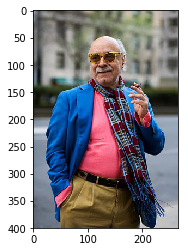

----------------------------------------------------------
the predictions are:  ['long_sleeves', 'outerwear', 'male']


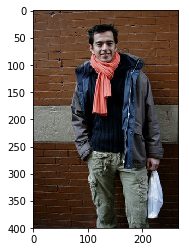

----------------------------------------------------------
the predictions are:  ['long_sleeves', 'suit', 'male']


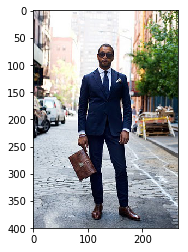

----------------------------------------------------------
the predictions are:  ['no_sleeves', 'tank_top', 'female']


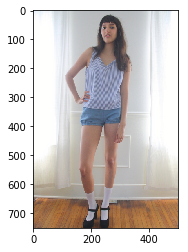

----------------------------------------------------------
the predictions are:  ['short_sleeves', 't_shirt', 'male']


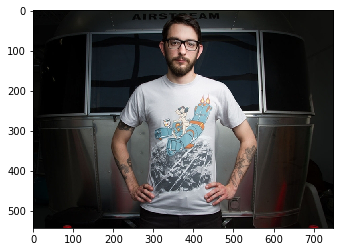

----------------------------------------------------------
the predictions are:  ['no_sleeves', 'dress', 'female']


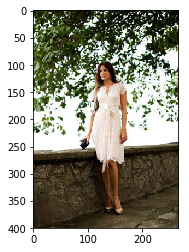

----------------------------------------------------------
the predictions are:  ['long_sleeves', 'dress', 'female']


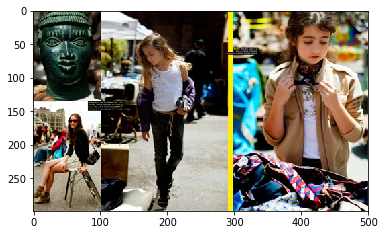

----------------------------------------------------------
the predictions are:  ['no_sleeves', 'dress', 'female']


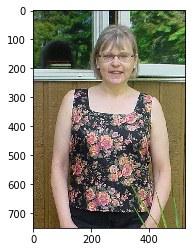

----------------------------------------------------------
the predictions are:  ['long_sleeves', 'outerwear', 'female']


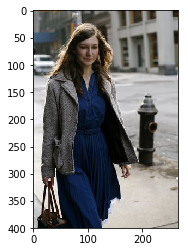

----------------------------------------------------------
the predictions are:  ['short_sleeves', 'dress', 'female']


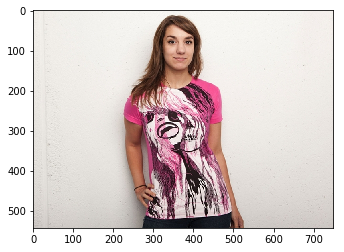

----------------------------------------------------------


In [44]:
get_predictions(combined_name_dict)

some observations and further possible improvements:
1. training accuracy can be seen to be nearly perfect and training loss going down to zero pretty much, not surprising to see that for such a small dataset..
2. bigger (and better) dataset (ideally)! this one has lot of nan values; haven't used those data samples here, further reducing the data set size and learning..
2. the label 'category' test accuracy is okay-ish wrt to other labels'; might be because this label has high % of nan values(not used) --> most information loss..